# 1. Data Preparation

In [1]:
# Import Libraries Used in Data Preparation
import pandas as pd
import os
debug = True
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import matplotlib.pyplot as plt

### 1.1 Load Data from files

In [2]:
#Code to Load Data in a DataFrame
datafolder = '../data/'
#print(os.listdir(datafolder))
train_features_file_name = 'train_features.csv'
train_labels_file_name = 'train_salaries.csv'
test_features_file_name = 'test_features.csv'

# with open(os.path.join(datafolder, test_features_file_name)) as f:
#     x = f.readlines()
# print(x[1])
train_data_features = pd.read_csv(os.path.join(datafolder, train_features_file_name))
org_features = train_data_features.columns.tolist()
train_data_labels = pd.read_csv(os.path.join(datafolder, train_labels_file_name))
train_full = pd.merge(train_data_features, train_data_labels, on='jobId',how ='inner')
test_data_features = pd.read_csv(os.path.join(datafolder, test_features_file_name))

assert(train_full.shape[0] == train_data_features.shape[0])
assert(train_full.shape[0] == train_data_labels.shape[0])
#train_full.dropna(how ='any', inplace = True)
#train_full.shape

### 1.2 Clean/Check Data (Pending)

In [3]:
#Check train Data for any null values
train_full.isnull().sum()


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [4]:
#Check Test Data for any null values
test_data_features.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

** No null values found so no data cleaning performed **

###  1.3 Encode Categorical Variables

In [5]:
# Create copies of original train and test data
train_full_encoded = train_full
test_data_features_encoded = test_data_features

** 1.3.1 One Hot Encoding : Done for *companyId*, *major*, and *industry* as these variabes are categories and may influence the salary **

In [6]:
#Encode Categorical Variables One Hot (both test and train)

def one_hot_encoding(c, df):
    new_f_name = 'OH_'+ c
    df = pd.concat([df, pd.get_dummies(df[c], prefix= new_f_name)], axis=1)
    return df, new_f_name

cat_features_normal = ['companyId', 'major', 'industry']
cat_features_normal_new = []
for c in cat_features_normal:
    train_full_encoded, new_f_name = one_hot_encoding(c, train_full_encoded)
    test_data_features_encoded, new_f_name_test = one_hot_encoding(c, test_data_features_encoded)
    cat_features_normal_new.append(new_f_name)
    
    
print(cat_features_normal_new)
#train_full.head(1)

['OH_companyId', 'OH_major', 'OH_industry']


** 1.3.2 Ordinal  Encoding : Done for *degree* and *jobType* as these variabes have an inherent order associated with them **

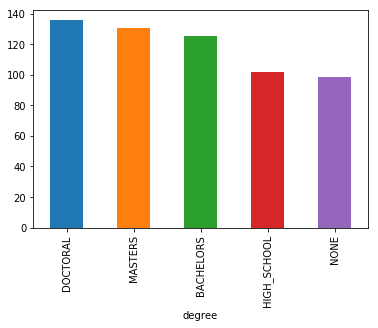

In [7]:
# Plot Information about Salaries vs Degree
dType = train_full_encoded.groupby('degree')['salary'].mean().sort_values(ascending=False)
dType.plot(kind='bar',x='degree',y='salary')
plt.show()

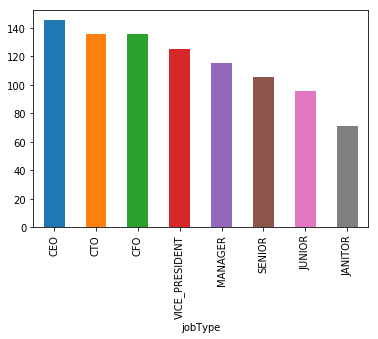

In [8]:
# Plot Information about Salaries vs JobType
jType = train_full_encoded.groupby('jobType')['salary'].mean().sort_values(ascending=False)
jType.plot(kind='bar',x='jobType',y='salary')
plt.show()

In [9]:
#Encode Categorical Variables Ordered (both test and train)

def ordinal_encoding(c, df, lookup):
    new_f_name = 'ORD_'+ c
    df[new_f_name] =  df[c].map(lookup)
    return df, new_f_name

degreeOrder = {'BACHELORS':2, 'DOCTORAL':4, 'HIGH_SCHOOL':1, 'MASTERS':3, 'NONE':0}
jobTypeOrder = {'CEO':6, 'CFO':5, 'CTO':5, 'VICE_PRESIDENT':4, 'MANAGER':3,'SENIOR':2, 'JUNIOR':1, 'JANITOR':0}

cat_features_ordinal = ['jobType', 'degree']
cat_features_ordinal_new = []
for c in cat_features_ordinal:
    train_full_encoded, new_f_name = ordinal_encoding(c, train_full_encoded, eval(c+'Order'))
    test_data_features_encoded, new_f_name_test = ordinal_encoding(c, test_data_features_encoded, eval(c+'Order'))
    cat_features_ordinal_new.append(new_f_name)

print(cat_features_ordinal_new)
#train_full.head(1)

['ORD_jobType', 'ORD_degree']


### 1.4 Shuffle Data and Split into K folds which are used during model selection

In [10]:
#Shuffle Train Data
train_full_encoded =  train_full_encoded.sample(frac=1).reset_index(drop=True)

In [11]:
# Split Data into K Folds
from sklearn.model_selection import KFold
def GetKFoldData(df,k):
    folds = {}
    kfolds = KFold(n_splits=k, shuffle = True, random_state = 4) 
    foldidx = 0
    for train_idx, test_idx in kfolds.split(df.index):
        folds[foldidx] = { 'train': df.iloc[train_idx], 'test':df.iloc[test_idx]}
        foldidx+=1
    return folds

#exp_data_k_folds = GetKFoldData(train_full, 10)
#idx_list_org = exp_data_k_folds[0]['test'].index.tolist()
#exp_data_k_folds[0]['test'].shape


### 1.5 Set Scaler to be used

In [12]:
# Use Standard Scaler
scalermain = preprocessing.StandardScaler()
#scalermain = preprocessing.MinMaxScaler()

# 2. Model Selection

### 2.1 Decide Features to Use and Models to Evaluate (Feature Scaling Pending)

** 2.1.1 Features to be Used (Filtered out non-encoded variables). Also marked out features which would be scaled **

In [13]:
# Select Features
non_cat_features = ['yearsExperience', 'milesFromMetropolis']
cat_features =[]
for f in train_full_encoded.columns:
    if 'OH' in f or 'ORD' in f:
        cat_features.append(f)
        
#train_full[train_features].head()
all_features = non_cat_features + cat_features 
features_to_scale = non_cat_features + cat_features_ordinal_new
#train_features

** 2.1.2 Regression Models Considered **

In [14]:
# Different Regression Models Evaluated
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor


models = {
            'LR' :    {'modelobj' :  linear_model.LinearRegression(), 'MSE':None, 'RMSE':None,\
                                     'Avg_Training_Time':None,'Avg_Testing_Time':None},
    
            'Ridge' : {'modelobj' :  linear_model.Ridge(), 'MSE':None, 'RMSE':None,\
                                     'Avg_Training_Time':None,'Avg_Testing_Time':None,\
                                     'params' : {'alpha': [i for i in range(1,81,3)]}},
    
            'DT' :    {'modelobj' :  DecisionTreeRegressor(random_state=10), 'MSE':None, 'RMSE':None, \
                                     'Avg_Training_Time':None,'Avg_Testing_Time':None, \
                                     'params' : {
                                                 'max_depth':[i for i in range(9,12)], \
                                                 'min_samples_leaf' :[i for i in range(10,21,5)]
                                                }}#,   
    
#             'RF' :    {'modelobj' :  RandomForestRegressor(random_state=10), 'MSE':None, 'RMSE':None, \
#                                      'Avg_Training_Time':None,'Avg_Testing_Time':None, \
#                                      'params' : {
#                                                  'n_estimators':[i for i in range(300,501,100)],
#                                                  'max_depth':[i for i in range(9,12)], 
#                                                  'min_samples_leaf' :[i for i in range(10,21,5)],
#                                                  'max_features' : ['log2', 'sqrt']
#                                                  }},
    
#               'GBR' :    {'modelobj' :   GradientBoostingRegressor(), 'MSE':None, 'RMSE':None, \
#                                      'Avg_Training_Time':None,'Avg_Testing_Time':None, \
#                                      'params' : {}}
                                                 
   
    
         
         }


### 2.2 Select Model

In [15]:
# Helper Functions to Evaluate a Model given train and test data
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
import time

def EvalModelSplitData(m, model, curr_fold, all_features, features_to_scale, \
                       scaler = preprocessing.StandardScaler()):
    
    #Train Data Selection
    curr_fold_X_train = curr_fold['train'][all_features]
    curr_fold_X_train_scaled= curr_fold_X_train
    curr_fold_X_train_scaled[features_to_scale] = scaler.fit_transform(curr_fold_X_train[features_to_scale])
    curr_fold_y_train = curr_fold['train']['salary'] 
    
    tr_st = time.time()
    curr_model = model['modelobj'].fit(curr_fold_X_train_scaled, curr_fold_y_train)
    tr_time = time.time() - tr_st
    
    
    #Test
    curr_fold_X_test = curr_fold['test'][all_features]
    curr_fold_X_test_scaled = curr_fold_X_test
    curr_fold_X_test_scaled[features_to_scale] = scaler.fit_transform(curr_fold_X_test[features_to_scale])
    curr_fold_y_test = curr_fold['test']['salary']
    
    tst_st = time.time()
    curr_test_predict = curr_model.predict(curr_fold_X_test_scaled)
    tst_time = time.time() - tst_st
    
    #Compute Cost (MSE/RMSE)
    curr_fold_mse = MSE(curr_test_predict, curr_fold_y_test)
    curr_fold_rmse = curr_fold_mse**0.5
    
    return curr_fold_mse, curr_fold_rmse, tr_time, tst_time
    

def GetBestParams(m, model, alldata, all_features, features_to_scale, k,\
                  scaler = preprocessing.StandardScaler()):
                  
    X_train = alldata[all_features]
    y_train = alldata['salary']
    X_train_scaled = X_train
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    
    
    if m in ['Ridge','DT']:
        model_search = GridSearchCV(model['modelobj'], model['params'], cv=k, verbose=0, n_jobs=-1,\
                                    scoring ='neg_mean_squared_error')
        model_search.fit(X_train_scaled, y_train)
        best_model = model_search.best_estimator_
        return best_model
    elif m in ['RF','GBR']:
        model_search = GridSearchCV(model['modelobj'], model['params'],verbose=0, n_jobs=-1,\
                                    scoring ='neg_mean_squared_error')
        model_search.fit(X_train_scaled, y_train)
        best_model = model_search.best_estimator_
        return best_model
    else:
        return model['modelobj']        


** 2.2.1 Run Grid Search on all models to get initial best performing parameters **

In [16]:
#Get Model Params Using Grid Search CV

def RunExpOnAllData(models,all_features,features_to_scale, alldata, sc = preprocessing.StandardScaler()):
    for m in models:
        print('Finding Best Params for : ', m)
        models[m]['modelobj'] = GetBestParams(m, models[m], alldata, all_features,features_to_scale, 5, sc)
        print('Best Params Found for : ', m)
        print()


RunExpOnAllData(models, all_features,features_to_scale, train_full_encoded, scalermain)

Finding Best Params for :  LR
Best Params Found for :  LR

Finding Best Params for :  Ridge
Best Params Found for :  Ridge

Finding Best Params for :  DT
Best Params Found for :  DT



** 2.2.2  Evaluate all models to see what perfoms best on differnt folds created in 1.4 **

In [17]:
# Find model performance vased on k-fold data created earlier ( See 1.4)
import multiprocessing as mp



def RunExpOnSplitData(kfolddata, models, all_features,features_to_scale, sc = preprocessing.StandardScaler()):
    for m in models:
        pool = mp.Pool(mp.cpu_count() -1 )
        #MSE_RMSE_results = pool.starmap(EvalModel, [ (models[m], kfolddata[curr_fold], train_features) for curr_fold in kfolddata])
        MSE_RMSE_results = pool.starmap_async(EvalModelSplitData, [(m, models[m], kfolddata[curr_fold], all_features,features_to_scale, sc) for curr_fold in kfolddata]).get()
        pool.close()
    
        models[m]['MSE'] = sum([i[0] for i in MSE_RMSE_results])/len(MSE_RMSE_results)
        models[m]['RMSE'] = sum([i[1] for i in MSE_RMSE_results])/len(MSE_RMSE_results)
        models[m]['Avg_Training_Time'] = sum([i[2] for i in MSE_RMSE_results])/len(MSE_RMSE_results)
        models[m]['Avg_Testing_Time'] = sum([i[3] for i in MSE_RMSE_results])/len(MSE_RMSE_results)
        
        #print(m, models[m]['MSE'], models[m]['RMSE'],models[m]['Avg_Training_Time'],models[m]['Avg_Testing_Time'], k)              

k = 10
kfolddata =  GetKFoldData(train_full_encoded, k)    
RunExpOnSplitData(kfolddata, models, all_features,features_to_scale, scalermain)
models_df =  pd.DataFrame.from_dict(models, orient='index')
models_df.index.name = 'Model Evaluated'
models_df[['MSE','RMSE','Avg_Training_Time','Avg_Testing_Time']]

,MSE,RMSE,Avg_Training_Time,Avg_Testing_Time
Model Evaluated,,,,
DT,422.077686,20.544484,15.673425,0.071624
LR,385.132180,19.624730,4.968828,0.061541
Ridge,385.131589,19.624715,1.407114,0.054439


** Based on above resuts the  *Ridge* regression model will be used for further experiments in this notebook **

** 2.2.3  Choose the model to be used **

In [19]:
#Choose Model Having the least RMSE on average over k-fold data
modelchosen = ('LR',models['LR'])
for m in models:
    if models[m]['RMSE']<modelchosen[1]['RMSE']:
        modelchosen = (m,models[m])

print(modelchosen[0], ' is the model choosen')

Ridge  is the model choosen


# 3. Feature Importance w.r.t best Model

For the best performing model I have tried to measure feature importance based on the impact they cause when the feature has been removed. (I have removed the features from the original category and not the encoded ones)

### 3.1 Features whose importance is to be checked

In [20]:
#Features whose importance will be evaluated
org_features = org_features[1:]
org_features

['companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis']

### 3.2 Remove each feature at a time and compute/display the percentage increase in RMSE

In [21]:
#Check change in RMSE performance on k-fold data when a feature is excluded for the best performig model
feature_imp_results = {}

# IF required feature importance can be checked over all the models also
#for m in models:
#    modelchosen = (m, models[m])

for f in org_features:
    try:

        all_features_wo_curr_f = [of for of in all_features if f not in of]
        features_to_scale_wo_curr_f = [of for of in features_to_scale if f not in of]         

        pool = mp.Pool(mp.cpu_count() -1 )
        mse_rmse_results = pool.starmap_async(EvalModelSplitData, [(modelchosen[0], modelchosen[1], kfolddata[curr_fold], all_features_wo_curr_f, features_to_scale_wo_curr_f, scalermain) \
                                                                   for curr_fold in kfolddata]).get()
        pool.close()
        if f not in feature_imp_results:
            feature_imp_results[f] = {}
            feature_imp_results[f]['Model'] = modelchosen[0]
            feature_imp_results[f]['MSE'] = sum([i[0] for i in mse_rmse_results])/len(mse_rmse_results)
            feature_imp_results[f]['RMSE'] = sum([i[1] for i in mse_rmse_results])/len(mse_rmse_results)
            feature_imp_results[f]['ORG_RMSE'] = modelchosen[1]['RMSE']
            feature_imp_results[f]['Percentage_increase_RMSE'] = 100 * (feature_imp_results[f]['RMSE'] - modelchosen[1]['RMSE'])/modelchosen[1]['RMSE']
    except:
        print('Exception occured while evlaluation importance of feature', f)


In [22]:
#Display how much is the increase in error when a feature is dropped
feature_imp_results_df = pd.DataFrame.from_dict(feature_imp_results, orient='index')
feature_imp_results_df.index.name = 'Feature Removed'
feature_imp_results_df.sort_values(by='Percentage_increase_RMSE', ascending=False)

,Model,MSE,RMSE,ORG_RMSE,Percentage_increase_RMSE
Feature Removed,,,,,
jobType,Ridge,774.502307,27.829779,19.624715,41.809850
yearsExperience,Ridge,595.346519,24.399662,19.624715,24.331291
milesFromMetropolis,Ridge,518.218124,22.764351,19.624715,15.998374
industry,Ridge,515.256481,22.699220,19.624715,15.666492
degree,Ridge,404.090803,20.101950,19.624715,2.431806
major,Ridge,401.354840,20.033781,19.624715,2.084439
companyId,Ridge,385.108871,19.624136,19.624715,-0.002950


** From above resuts it is evident that *JobType* has the most predictive power whereas the feature *companyId* has the least predicitve power **

In [23]:
# feature_imp = feature_imp_results_df.groupby('Model')
# feature_imp.sort_values(by='percentage_error_increase', ascending=False)

# 4. Predict Salaries for Test Data

A prediction of salaries is made for the test data based on the best model chosen above. The test data has been already been encoded in the same way as before and the scaling of numerica features is same as performed with the trianing data

### 4.1 Predict Salaries 

In [24]:
#Helper Function to Predict Salaries Given testdata, model and scaling scheme
def PredictSalary(m, model, train_full, test_data, all_features, features_to_scale, \
                       scaler = preprocessing.StandardScaler()):
        
    #train_model_full_data
    X_train = train_full[all_features]
    X_train_scaled = X_train
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    y_train = train_full['salary'] 
    
    tr_st = time.time()
    trained_model = model['modelobj'].fit(X_train_scaled, y_train)
    tr_time = time.time() - tr_st 
    
    #Test
    X_test = test_data[all_features]
    X_test_scaled = X_test
    X_test_scaled[features_to_scale] = scaler.fit_transform(test_data[features_to_scale])
    
    tst_st = time.time()
    test_predictions = trained_model.predict(X_test_scaled)
    tst_time = time.time() - tst_st
    
    test_data['salary'] = test_predictions 
    
    return test_data

def get_currtime_str():
    from datetime import datetime
    """ Gets the current time in a particular format  """

    timestampformat = '%Y%m%d__%H%M%S'
    currtime_str = str(datetime.now().strftime(timestampformat))
    return currtime_str

In [25]:
#Predict Salaries of Test Data Based on Chosen Model and save the predictions in a csv file
test_salaries = PredictSalary(modelchosen[0], modelchosen[1],train_full_encoded, test_data_features_encoded, all_features, features_to_scale, \
                          scalermain)
assert(test_salaries.shape[0]==test_data_features_encoded.shape[0])


### 4.2 Save predicted salaries to csv file

In [26]:
currtime = get_currtime_str()
test_salaries[['jobId','salary']].to_csv(currtime+'_test_salaries.csv', index = False)
test_data_features_encoded.to_csv('test_full.csv', index = False)
print(" Predicted Salaries for test data saved in file ", currtime+'_test_salaries.csv')

 Predicted Salaries for test data saved in file  20190326__201341_test_salaries.csv


# 5. Estimating RMSE of Test Data

In [27]:
# Sample some of the test datat and then get similarity betweeen test data sample and training data jobs
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import *
from scipy import spatial
import scipy 


samplesize = 500
#Get Scaled Data
train_full_encoded_scaled = train_full_encoded
test_data_features_encoded_scaled_sample = test_data_features_encoded.sample(n=samplesize, random_state=0)


train_full_encoded_scaled[features_to_scale] = scalermain.fit_transform(train_full_encoded_scaled[features_to_scale])
test_data_features_encoded_scaled_sample[features_to_scale] = \
                        scalermain.fit_transform(test_data_features_encoded_scaled_sample[features_to_scale])


#Create Sparse Matrices of Train and Test Data
TRNG_MAT = scipy.sparse.csr_matrix(train_full_encoded_scaled[all_features].values)
TST_MAT = scipy.sparse.csr_matrix(test_data_features_encoded_scaled_sample[all_features].values)
sim = cosine_similarity(TST_MAT, TRNG_MAT)



In [28]:
# Get the index of most similar row in Training data w.r.t each row in test data sample
max_idx_list = np.argmax(sim, axis=1).tolist()
test_data_features_encoded_scaled_sample['most_similar_row'] = max_idx_list

In [29]:
# Set the salary of each row in test data sample as equal to the salary of most similar row in traning_data
def getSalFromTrainData(rowidx,trdata):
    return trdata.iloc[rowidx]['salary']

test_data_features_encoded_scaled_sample['most_similar_salary'] =\
    test_data_features_encoded_scaled_sample['most_similar_row'].apply(getSalFromTrainData, args=( train_full_encoded,))


In [30]:
# GET MSE for each row in test data sample as well as RMSE for whole sampled data
def computeMSE(r):
    return MSE([r['salary']], [r['most_similar_salary']])
    #return MSE(x['salary'], x['most_similar_salary'])


test_data_features_encoded_scaled_sample['MSE'] = \
                    test_data_features_encoded_scaled_sample.apply(computeMSE, axis =1)
pred_rmse = test_data_features_encoded_scaled_sample['MSE'].mean() ** 0.5
pred_rmse

20.32023302836884

In [31]:
# Estimate MSE Range based on MSE for each row in sample and based on that RMSE range
from scipy.stats import sem as stderr
from scipy.stats import t as tscore
from scipy import mean

MSEList = test_data_features_encoded_scaled_sample['MSE'].tolist()

confidence_level = 0.95
no_of_data_points = len(MSEList)
mu = mean(MSEList)
std_err = stderr(MSEList)
error_range = std_err * tscore.ppf((1 + confidence_level) / 2, no_of_data_points - 1)
error_range

est_MSERange = (mu-error_range, mu + error_range)
est_RMSERange = ((mu-error_range)**0.5, (mu+error_range)**0.5)
est_RMSERange
print(" Based on " + str(no_of_data_points) +" samples The estimated RMSE on the test data set should be in the range \n " + \
      str(est_RMSERange) + " with a confidence_level of " + str(confidence_level))

 Based on 500 samples The estimated RMSE on the test data set should be in the range 
 (18.92102315845753, 21.62911517588128) with a confidence_level of 0.95
